In [1]:
import time
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, utils, models
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
np.random.seed(24)
torch.manual_seed(24)
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

PROJ_ROOT = os.pardir
data_dir = os.path.join(PROJ_ROOT, 'transfer-learning', 'dataset')

In [2]:
cloudy_path = Path('dataset', 'cloudy')
rain_path = Path('dataset', 'rain')
sunrise_path = Path('dataset', 'sunrise')
shine_path = Path('dataset', 'shine')

In [3]:
def show_img(img_path):
    img = plt.imread(img_path)
    plt.imshow(img)
    
def show_pillow(img_path):
    Image.open(img_path)

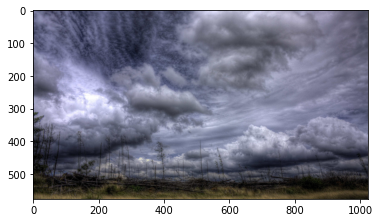

In [4]:
cloudy = cloudy_path / 'cloudy8.jpg'
show_img(cloudy)

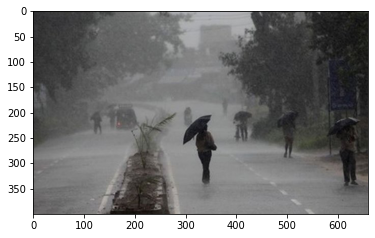

In [5]:
rain = rain_path / 'rain10.jpg'
show_img(rain)

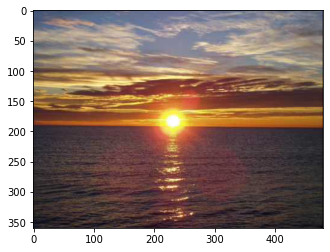

In [6]:
sunrise = sunrise_path / 'sunrise12.jpg'
show_img(sunrise)

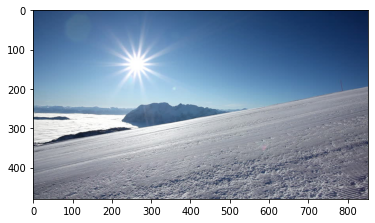

In [7]:
shine = shine_path / 'shine24.jpg'
show_img(shine)

### Data Augmentation

In [8]:
img_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':
    transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

### Data Iterators

In [9]:
train_test_split=0.85
train_val_split=0.15
batch_size=16
shuffle=True


np.random.seed(24)
train_ds = datasets.ImageFolder(root=data_dir, transform=img_transforms['train'])
val_ds = datasets.ImageFolder(root=data_dir, transform=img_transforms['val'])
test_ds = datasets.ImageFolder(root=data_dir, transform=img_transforms['val'])
img_count = len(train_ds)
indices = list(range(img_count))
test_split = int(img_count * train_test_split)
if shuffle:
    np.random.shuffle(indices)
train_idx, test_idx = indices[:test_split], indices[test_split:]
train_count = len(train_idx)
val_split = int(train_count * (1 - train_val_split))
train_idx, val_idx = train_idx[:val_split], train_idx[val_split:]
train_sample = SubsetRandomSampler(train_idx)
val_sample = SubsetRandomSampler(val_idx)
test_sample = SubsetRandomSampler(test_idx)
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=train_sample)
val_loader = DataLoader(val_ds, batch_size=batch_size, sampler=val_sample)
test_loader = DataLoader(test_ds, batch_size=batch_size, sampler=test_sample)

In [10]:
train_iter = iter(train_loader)
feats, labels = next(train_iter)
feats.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

### Pre-trained Models

In [11]:
def get_pretrained_model(model, n_classes):
    
    if model == 'vgg16':
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2), 
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
        
    elif model == 'resnet50':
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
        
    return model

In [12]:
model = get_pretrained_model('resnet50', 4)

In [13]:
optimizer = optim.Adam(model.parameters())

# observe weights that will be updated during training
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])


In [15]:
def train(model, 
          loss_fn,
          optimizer,
          train_loader,
          val_loader,
          #save_file_name,
          n_epochs=10,
          patience=3):
    
    device = torch.device('cpu')
    epochs = 0
    epochs_patience = 0
    val_loss_min = np.Inf
    val_acc_max = 0
    history = []
    for epoch in range(1, n_epochs+1):
        
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0
        val_acc = 0
        
        model.train()
        start = time.time()
        for batch, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model.forward(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, preds = torch.max(output, dim=1)
            correct = preds.eq(target.data.view_as(preds))
            accuracy = torch.mean(correct.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_acc / len(train_loader.sampler)
        epochs += 1
        with torch.no_grad():
            model.eval()
            for data, target in val_loader:
                output = model.forward(data)
                loss = loss_fn(output, target)
                val_loss += loss.item() * data.size(0)
                _, preds = torch.max(output, dim=1)
                correct = preds.eq(target.data.view_as(preds))
                accuracy = torch.mean(
                    correct.type(torch.FloatTensor))
                val_acc += accuracy.item() * data.size(0)
            val_loss = val_loss / len(val_loader.sampler)
            val_acc = val_acc / len(val_loader.sampler)
            history.append([train_loss, val_loss, train_acc, val_acc])
            print(f'[Epoch: {epoch}/{n_epochs} train loss {train_loss:.6f}'
                  f' train acc {train_acc:.3f} val loss {val_loss:.6f}'
                  f' val acc {val_acc:.3f}]')
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'val_loss', 'train_acc', 'val_acc'])
    
    return model, history

In [ ]:
model, history = train(
    model, 
    nn.NLLLoss(),
    optimizer,
    train_loader,
    val_loader,
)